In [1]:
# Mengimpor library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Menghilangkan warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load dataset
df = pd.read_excel('NK_PREDICT_FIX.xlsx')

# Melihat tampilan dataset
df.head()

,time,nk,coal_flow,beban_gross,sfc,lsh_fluegas_in_temp,lsh_fluegas_out_temp,total_airflow,flue_gas_co
0,2021-05-01 11:00:00,3924.35,231.186554,305.868958,0.755171,481.927948,416.704651,1935.620483,25.569004
1,2021-05-01 12:00:00,3924.35,248.907288,328.868347,0.758238,518.689453,435.932251,1913.147827,34.158985
2,2021-05-01 13:00:00,3924.35,289.626587,403.812714,0.722182,542.494690,452.560822,2059.362305,7.804508
3,2021-05-01 14:00:00,3924.35,309.465240,449.182800,0.694248,553.735291,463.656036,2098.245361,3.220061
4,2021-05-01 15:00:00,3924.35,331.529053,499.315765,0.663505,576.978088,478.122406,2209.166016,2.852528


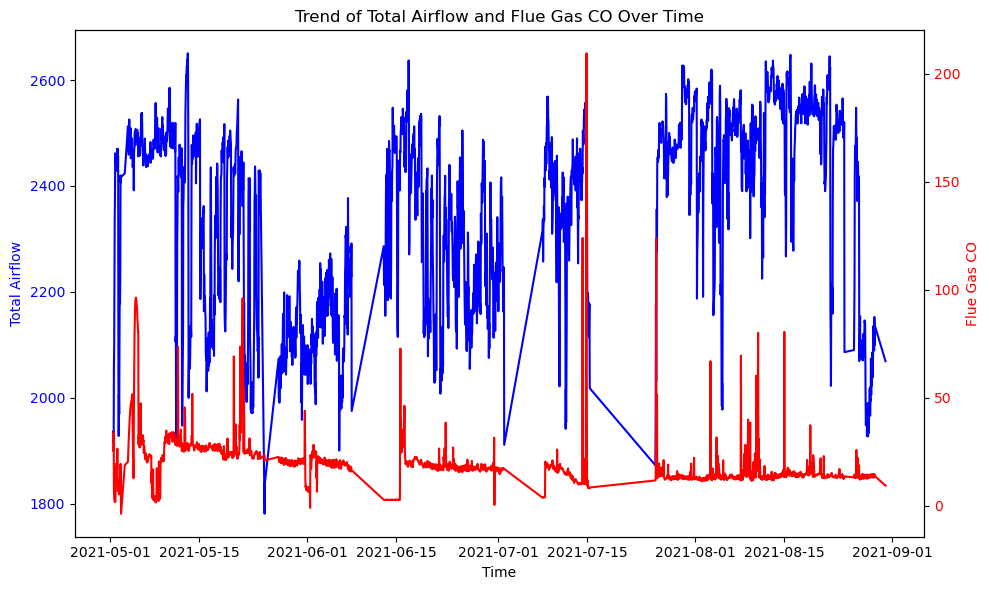

In [6]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot total_airflow on the first y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Airflow', color='b')
ax1.plot(df['time'], df['total_airflow'], color='b', label='Total Airflow')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for flue_gas_co
ax2 = ax1.twinx()
ax2.set_ylabel('Flue Gas CO', color='r')
ax2.plot(df['time'], df['flue_gas_co'], color='r', label='Flue Gas CO')
ax2.tick_params(axis='y', labelcolor='r')

# Adding title
plt.title('Trend of Total Airflow and Flue Gas CO Over Time')

# Show plot
plt.tight_layout()
plt.show()

In [11]:


# Mengatur gaya visual seaborn
sns.set(style="whitegrid")

# Mengonversi kolom waktu menjadi format datetime jika belum
df['time'] = pd.to_datetime(df['time'])

# Membuat scatter plot dengan waktu sebagai warna
plt.figure(figsize=(12, 8))
sns.scatterplot(x='total_airflow', y='flue_gas_co', hue='time', palette='viridis', data=df, alpha=0.7)
plt.title('Hubungan antara Total Airflow dan Flue Gas CO dengan Waktu')
plt.xlabel('Total Airflow')
plt.ylabel('Flue Gas CO')
plt.colorbar(label='Waktu')
plt.show()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

Error in callback <function flush_figures at 0x000001BDB917E290> (for post_execute), with arguments args (),kwargs {}:


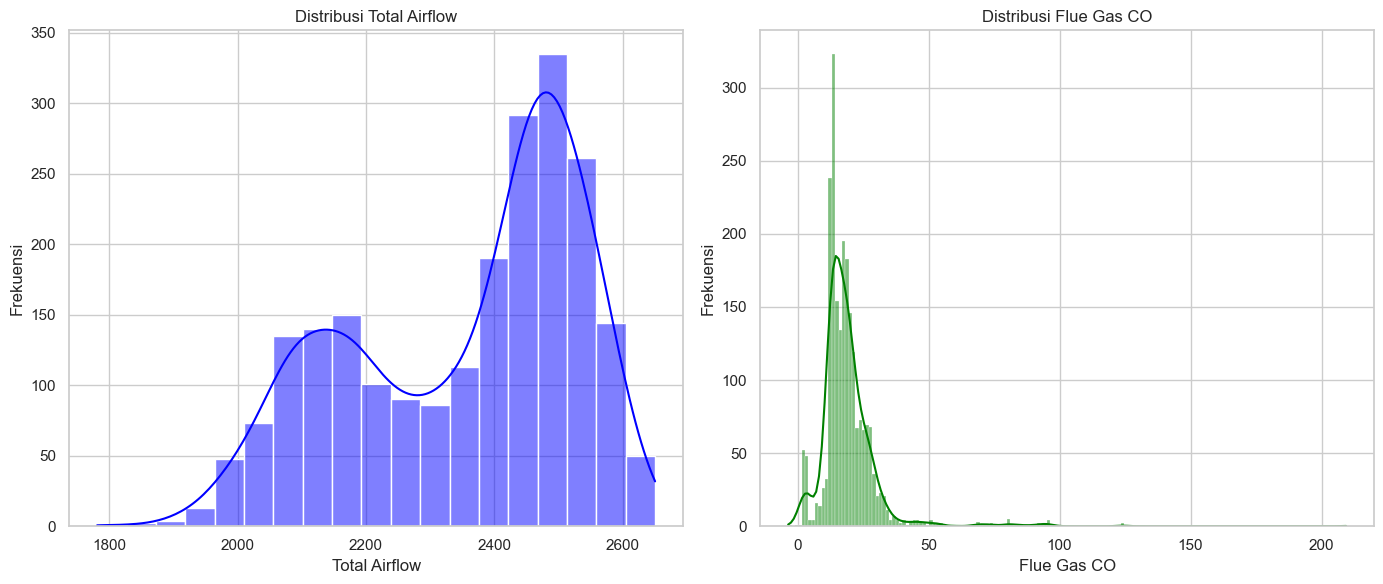

In [10]:
plt.figure(figsize=(14, 6))

# Histogram dan Density Plot untuk Total Airflow
plt.subplot(1, 2, 1)
sns.histplot(df['total_airflow'], kde=True, color='blue')
plt.title('Distribusi Total Airflow')
plt.xlabel('Total Airflow')
plt.ylabel('Frekuensi')

# Histogram dan Density Plot untuk Flue Gas CO
plt.subplot(1, 2, 2)
sns.histplot(df['flue_gas_co'], kde=True, color='green')
plt.title('Distribusi Flue Gas CO')
plt.xlabel('Flue Gas CO')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()


In [4]:
df = df.drop(columns=['time'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2228 entries, 0 to 2227
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nk                    2228 non-null   float64
 1   coal_flow             2228 non-null   float64
 2   beban_gross           2228 non-null   float64
 3   sfc                   2228 non-null   float64
 4   lsh_fluegas_in_temp   2228 non-null   float64
 5   lsh_fluegas_out_temp  2228 non-null   float64
 6   total_airflow         2228 non-null   float64
 7   flue_gas_co           2228 non-null   float64
dtypes: float64(8)
memory usage: 139.4 KB


In [6]:
df =  df[['coal_flow', 'flue_gas_co', 'nk', 'beban_gross']]

In [7]:
df.describe()

,coal_flow,flue_gas_co,nk,beban_gross
count,2228.000000,2228.000000,2228.000000,2228.000000
mean,344.187655,19.138252,4030.756768,507.657404
std,48.231198,11.662542,298.156064,79.534768
min,208.461349,-3.579429,3410.880000,300.069366
25%,305.194397,13.443896,3841.350000,450.654236
50%,355.955719,17.335576,4050.110000,508.376709
75%,384.640236,21.846228,4197.830000,574.986298
max,429.345947,209.370514,4851.630000,638.567444


In [8]:
# Hitung Q1 (kuartil pertama) dan Q3 (kuartil ketiga) untuk kolom 'flue_gas_co'
Q1 = df['flue_gas_co'].quantile(0.25)
Q3 = df['flue_gas_co'].quantile(0.75)

# Hitung IQR (Rentang Interkuartil)
IQR = Q3 - Q1

# Tentukan batas bawah dan atas untuk outlier
batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

# Batasi nilai minimal dan maksimal
batas_bawah = max(batas_bawah, 10)
batas_atas = min(batas_atas, 50)

# Hapus outlier dari kolom 'flue_gas_co'
df = df[(df['flue_gas_co'] >= batas_bawah) & (df['flue_gas_co'] <= batas_atas)]

In [9]:
# Hitung Q1 (kuartil pertama) dan Q3 (kuartil ketiga) untuk kolom 'flue_gas_co'
Q1 = df['coal_flow'].quantile(0.25)
Q3 = df['coal_flow'].quantile(0.75)

# Hitung IQR (Rentang Interkuartil)
IQR = Q3 - Q1

# Tentukan batas bawah dan atas untuk outlier
batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

# Batasi nilai minimal dan maksimal
batas_bawah = max(batas_bawah, 210)
batas_atas = min(batas_atas, 359)

# Hapus outlier dari kolom 'flue_gas_co'
df = df[(df['coal_flow'] >= batas_bawah) & (df['coal_flow'] <= batas_atas)]

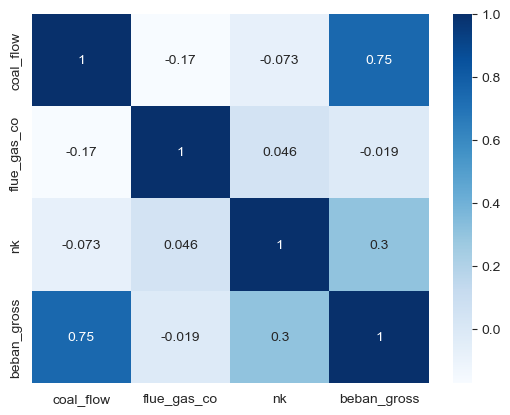

In [10]:
# Correlation matrix
sns.set_style("white")
sns.heatmap(df.corr(), cmap="Blues", annot=True);

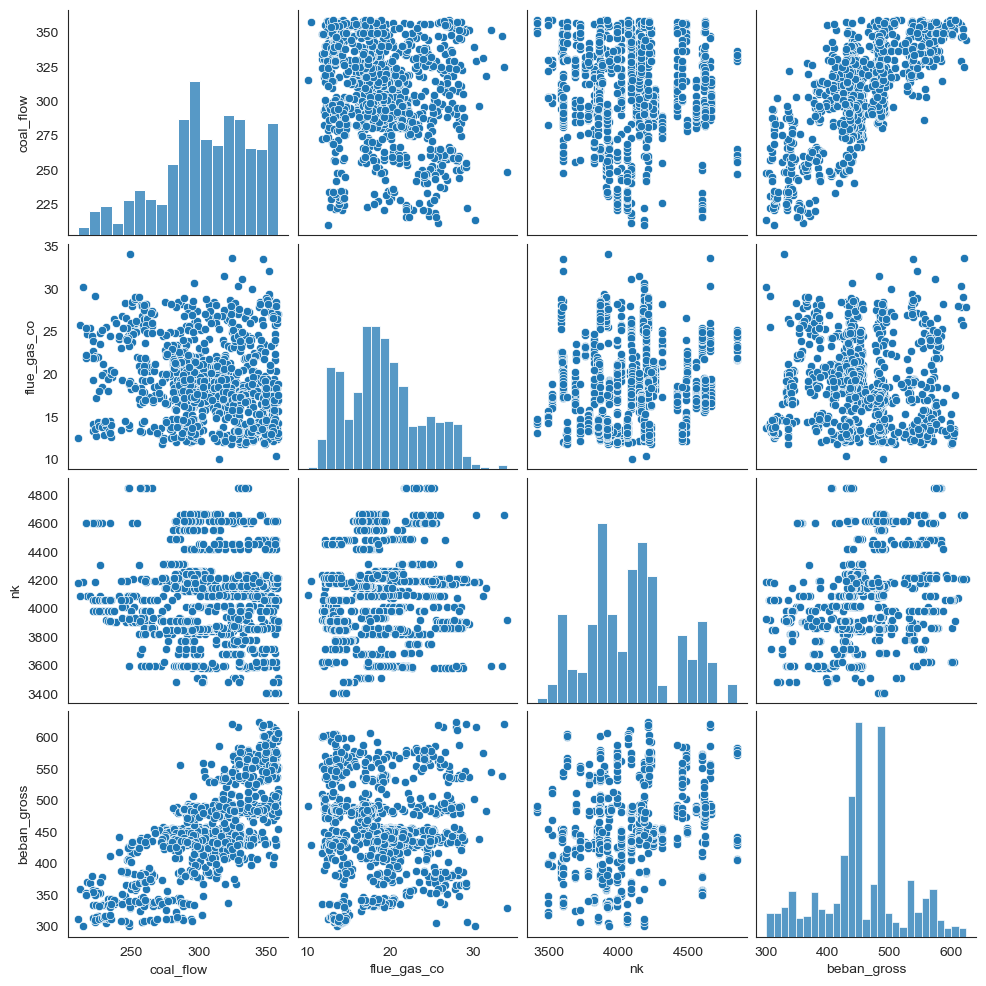

In [11]:
sns.pairplot(df)

In [12]:
# Mendefinisikan variabel target
target = 'coal_flow'

In [13]:
# Membagi kolom menjadi kolom numerik dan kategori
var_kategori = [var for var in df.columns if df[var].dtype=='O' and var!=target]
var_numerik = [var for var in df.columns if df[var].dtype!='O' and var!=target]

# Melihat variabel yang sudah dipisah
print(var_kategori)
print(var_numerik)

[]
['flue_gas_co', 'nk', 'beban_gross']


In [14]:
# Mengecek data kosong
df.isnull().mean()

coal_flow      0.0
flue_gas_co    0.0
nk             0.0
beban_gross    0.0
dtype: float64

In [15]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target], axis=1),
    df[target],
    test_size = 0.2,
    random_state = 0)

# Reset indeks dengan looping
for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)

# Melihat dimensi training dan test set
X_train.shape, X_test.shape

((848, 3), (212, 3))

In [16]:
# Membuat Pipeline untuk preprocessing
preprocessor_numerik = Pipeline([
    ('imputasi', SimpleImputer(strategy='median')),
    ('scaling', MinMaxScaler())
])

preprocessor_kategori = Pipeline([
    ('imputasi', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoding', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Menggabungkan kedua pipeline di atas
preprocessor = ColumnTransformer([
    ('preprocessing numerik', preprocessor_numerik, var_numerik),
    ('preprocessing kategori', preprocessor_kategori, var_kategori)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [17]:
# Membuat Pipeline untuk modeling
model_reg = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regresi', LinearRegression())
])

In [18]:
# Mengeksekusi Pipeline akhir
model_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('preprocessing numerik',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  ['flue_gas_co', 'nk',
                                                   'beban_gross']),
                                                 ('preprocessing kategori',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('regresi', LinearRegression())])

In [19]:
# Mencoba memprediksi training set (5 baris pertama)
model_reg.predict(X_train)[:5]

array([315.70689709, 348.54303388, 320.31115517, 298.75039286,
       259.03638883])

In [20]:
# Melihat intercept
print(model_reg['regresi'].intercept_)

# Melihat koefisien
print(model_reg['regresi'].coef_)

275.4005506881725
[-25.70988972 -53.32120622 135.49013362]


In [21]:
# Melihat nama kolom preprocessing
print(model_reg['preprocessing'].get_feature_names_out())

['flue_gas_co' 'nk' 'beban_gross']


In [22]:
# Looping untuk mencetak persamaan regresi linear
for i,j in enumerate(model_reg['regresi'].coef_):
    if i == 0:
        print(str(target),'=',model_reg['regresi'].intercept_,'+',model_reg['regresi'].coef_[i],'*',model_reg['preprocessing'].get_feature_names_out()[i],'+')
    elif i != len(model_reg['regresi'].coef_)-1:
        print(model_reg['regresi'].coef_[i],'*',model_reg['preprocessing'].get_feature_names_out()[i],'+')
    else:
        print(model_reg['regresi'].coef_[i],'*',model_reg['preprocessing'].get_feature_names_out()[i])

coal_flow = 275.4005506881725 + -25.709889723901846 * flue_gas_co +
-53.321206221360754 * nk +
135.49013362461434 * beban_gross


In [23]:
# Memprediksi X_train dan membandingkannya hasilnya dengan y_train
pred_train = model_reg.predict(X_train)

In [24]:
# Hasil prediksi training set
pred_train = pd.DataFrame(pred_train, columns=[target])
pred_train.head()

,coal_flow
0,315.706897
1,348.543034
2,320.311155
3,298.750393
4,259.036389


In [25]:
# Membandingkan 2 numpy array (kita gunakan np.column_stack untuk menggabungkan kedua array ini)
banding_train = pd.DataFrame(np.column_stack((pred_train, pd.DataFrame(y_train), abs(pred_train - pd.DataFrame(y_train)))), columns=['Prediksi', 'Asli', 'Error'])
banding_train.head()

,Prediksi,Asli,Error
0,315.706897,331.583710,15.876813
1,348.543034,335.404297,13.138737
2,320.311155,300.684875,19.626280
3,298.750393,316.898254,18.147862
4,259.036389,225.726212,33.310177


In [26]:
# Menghitung nilai rata-rata dari error yang sudah dibuat absolut (MAE = Mean absolute error)
banding_train.describe()

,Prediksi,Asli,Error
count,848.000000,848.000000,848.000000
mean,305.073840,305.073840,15.381873
std,28.171641,34.260846,11.970080
min,228.666003,211.916275,0.000681
25%,290.201435,286.414696,5.778122
50%,302.811808,306.624573,12.179542
75%,319.937173,330.715385,23.000679
max,392.138061,358.950989,58.227291


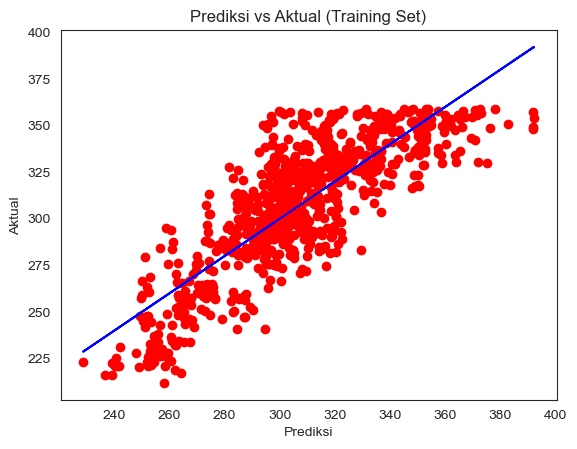

In [27]:
# Visualisasi hasil Training Set
plt.scatter(pred_train, y_train, color = 'red')
plt.plot(pred_train, model_reg.predict(X_train), color = 'blue')
plt.title('Prediksi vs Aktual (Training Set)')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [28]:
# Menghitung nilai error (MAE, MSE, RMSE) di Training Set
from sklearn import metrics
print('MAE = {}'.format(metrics.mean_absolute_error(y_train, pred_train)))           # MAE adalah nilai error rata-rata seperti yang ada di tabel banding_train
print('MSE = {}'.format(metrics.mean_squared_error(y_train, pred_train)))            # penulisan {0:.2f} adalah untuk menuliskan 2 angka di belakang koma
print('RMSE = {}'.format(np.sqrt(metrics.mean_squared_error(y_train, pred_train))))
print('R2 = {}'.format(metrics.r2_score(y_train, pred_train)))

MAE = 15.381873010805972
MSE = 379.7158689317671
RMSE = 19.486299518681506
R2 = 0.6761267850203494


In [29]:
# Memprediksi hasil Test set
pred_test = model_reg.predict(X_test)

In [30]:
# Hasil prediksi test set
pred_test = pd.DataFrame(pred_test, columns=[target])
pred_test.head()

,coal_flow
0,294.590096
1,330.728539
2,296.691747
3,290.337300
4,298.852704


In [31]:
# Membandingkan 2 numpy array (kita gunakan np.column_stack untuk menggabungkan kedua array ini)
banding_test = pd.DataFrame(np.column_stack((pred_test, pd.DataFrame(y_test), abs(pred_test - pd.DataFrame(y_test)))), columns=['Prediksi', 'Asli', 'Error'])
banding_test

,Prediksi,Asli,Error
0,294.590096,290.548340,4.041756
1,330.728539,338.721985,7.993446
2,296.691747,297.367249,0.675502
3,290.337300,259.865051,30.472249
4,298.852704,309.203613,10.350910
...,...,...,...
207,305.558400,330.925079,25.366680
208,249.196361,210.335876,38.860484
209,298.966066,297.278534,1.687532
210,311.156380,346.497589,35.341209


In [32]:
# Menghitung nilai rata-rata dari error yang sudah dibuat absolut di test set (MAE = Mean absolute error)
banding_test.describe()

,Prediksi,Asli,Error
count,212.000000,212.000000,212.000000
mean,306.744299,308.311509,15.442395
std,27.995353,33.439994,11.865700
min,224.653121,210.335876,0.184595
25%,290.988306,290.542595,6.386250
50%,304.748823,309.424179,12.451623
75%,319.409167,335.072289,21.830553
max,376.139520,358.397644,58.164345


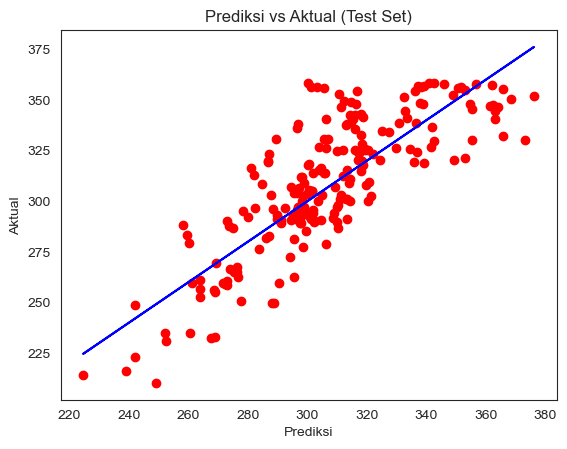

In [33]:
# Visualisasi hasil Test Set
plt.scatter(pred_test, y_test, color = 'red')
plt.plot(pred_test, model_reg.predict(X_test), color = 'blue')
plt.title('Prediksi vs Aktual (Test Set)')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [34]:
# Menghitung nilai error (MAE, MSE, RMSE) di Test Set
print('MAE = {0:.2f}'.format(metrics.mean_absolute_error(y_test, pred_test)))           # MAE adalah nilai error rata-rata seperti yang ada di tabel banding_train
print('MSE = {0:.2f}'.format(metrics.mean_squared_error(y_test, pred_test)))            # penulisan {0:.2f} adalah untuk menuliskan 2 angka di belakang koma
print('RMSE = {0:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, pred_test))))
print('R2 = {0:.2f}'.format(metrics.r2_score(y_test, pred_test)))

MAE = 15.44
MSE = 378.60
RMSE = 19.46
R2 = 0.66
